# Андреев Алексей ИУ5-23М

#### Описание датасета
> Датасет с данными о прокате велосипедов в Лондоне.

Данные в датасете представляют информацию о погодных условиях, дате/времени и количестве велосипедов взятых на прокат в Лондоне за несколько лет

#### Описание колонок
Год — год, когда велосипед взят в аренду.

Месяц — месяц, когда велосипед взят в аренду.

День — день, когда велосипед взят в аренду.

Время — время в часах, когда велосипед взят в аренду.

Количество велосипедов — количество велосипедов, которые были взяты напрокат.

Температура воздуха  — температура воздуха в градусах Цельсия.

Ощущаемая температура — температура воздуха, ощущаемую человеком в градусах Цельсия.

Влажность воздуха — текущую влажность воздуха, выраженную в процентах.

Скорость ветра — скорость ветра в километрах в час.

Код погоды — 1 - Ясно; 2 - Кучевые облака; 3 – Перистые облака 4 – Облачно; 7 - Дождь / Легкий дождь; 10 - Дождь с грозой; 26 – Снегопад; 94 - Замораживание тумана

Выбранный день - праздничный — 1 если праздничный день.

Выбранный день день - 1 если выходной.

Время года — 0-весна; 1-лето; 2-осень; 3-зима.


In [1]:
import random
from pprint import pprint

import pandas as pd
import numpy as np

import scipy.stats as stats

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv("london_merged.csv")

def set_some_nan(df, index, column):
    if random.random() < 0.3:
        df.at[index, column] = np.NaN

data.loc[data['season']==0, 'season'] = 'spring'
data.loc[data['season']==1, 'season'] = 'summer'
data.loc[data['season']==2, 'season'] = 'fall'
data.loc[data['season']==3, 'season'] = 'winter'


for i in range(data.shape[0]):
    set_some_nan(data, i, 'wind_speed')
    
    
data['hour'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).hour))
data
# Сезон — 0-весна; 1-лето; 2-осень; 3-зима.

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,winter,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,winter,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,NaN,1.0,0.0,1.0,winter,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,winter,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,winter,4
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,winter,19
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,winter,20
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,NaN,4.0,0.0,0.0,winter,21
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,winter,22


In [3]:
pprint({
    name: { 'type': type, 'nans': nans}
    for name, type, nans
    in zip(
        [i for i in data.columns],
        [str(i) for i in data.dtypes],
        [i for i in data.isnull().sum()]
    )
})

{'cnt': {'nans': 0, 'type': 'int64'},
 'hour': {'nans': 0, 'type': 'int64'},
 'hum': {'nans': 0, 'type': 'float64'},
 'is_holiday': {'nans': 0, 'type': 'float64'},
 'is_weekend': {'nans': 0, 'type': 'float64'},
 'season': {'nans': 0, 'type': 'object'},
 't1': {'nans': 0, 'type': 'float64'},
 't2': {'nans': 0, 'type': 'float64'},
 'timestamp': {'nans': 0, 'type': 'object'},
 'weather_code': {'nans': 0, 'type': 'float64'},
 'wind_speed': {'nans': 5270, 'type': 'float64'}}


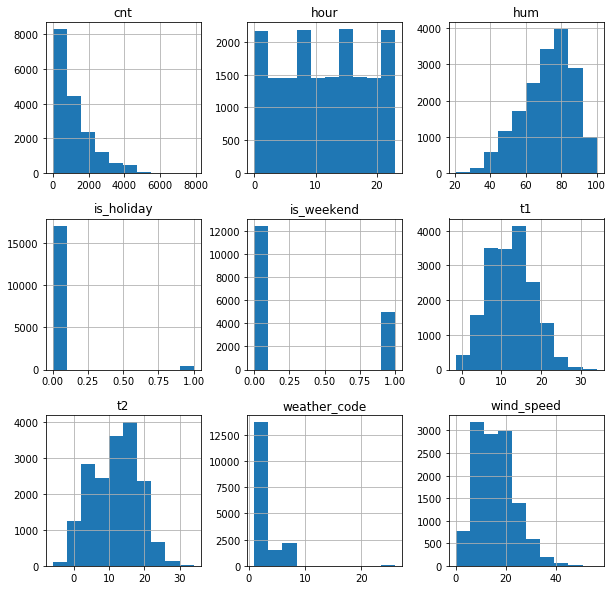

In [4]:
data.hist(figsize=(10,10));

# Устранение пропусков

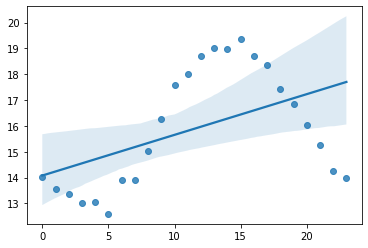

In [5]:
wind_speed_avg = []
hour_list = data['hour'].unique()
for hour in hour_list:
    wind_speed_avg.append(data[data['hour']==hour]['wind_speed'].mean())

sns.regplot(x=hour_list, y=wind_speed_avg);

Dидно, что скорость ветра имеет нормальное распределение, поэтому можно заменить пропуски на средние значения.

In [6]:
def replace_nan_to_mean(df, index, column, mean):
    if hash(data.at[index,column]) == 0 and data.at[index,column] != 0:
        df.at[index, column] = mean
        
mean = data['wind_speed'].mean()
for i in range(data.shape[0]):
    replace_nan_to_mean(data, i, 'wind_speed', mean)

pprint({
    name: { 'type': type, 'nans': nans}
    for name, type, nans
    in zip(
        [i for i in data.columns],
        [str(i) for i in data.dtypes],
        [i for i in data.isnull().sum()]
    )
})

{'cnt': {'nans': 0, 'type': 'int64'},
 'hour': {'nans': 0, 'type': 'int64'},
 'hum': {'nans': 0, 'type': 'float64'},
 'is_holiday': {'nans': 0, 'type': 'float64'},
 'is_weekend': {'nans': 0, 'type': 'float64'},
 'season': {'nans': 0, 'type': 'object'},
 't1': {'nans': 0, 'type': 'float64'},
 't2': {'nans': 0, 'type': 'float64'},
 'timestamp': {'nans': 0, 'type': 'object'},
 'weather_code': {'nans': 0, 'type': 'float64'},
 'wind_speed': {'nans': 0, 'type': 'float64'}}


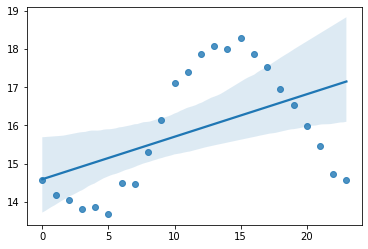

In [7]:
wind_speed_avg = []
hour_list = data['hour'].unique()
for hour in hour_list:
    wind_speed_avg.append(data[data['hour']==hour]['wind_speed'].mean())

sns.regplot(x=hour_list, y=wind_speed_avg);

# Кодирование категориальных признаков

In [8]:
seasons = list(data['season'].unique())
seasons

['winter' 'spring' 'summer' 'fall']


['winter', 'spring', 'summer', 'fall']

In [9]:
for i in range(data.shape[0]):
    num = seasons.index(data.at[i, 'season'])
    data.at[i, 'season'] = num
print(data['season'].unique())
data[:5]

[0 1 2 3]


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.000000,3.0,0.0,1.0,0,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.000000,1.0,0.0,1.0,0,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,15.877532,1.0,0.0,1.0,0,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.000000,1.0,0.0,1.0,0,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.500000,1.0,0.0,1.0,0,4


# Нормализация числовых признаков

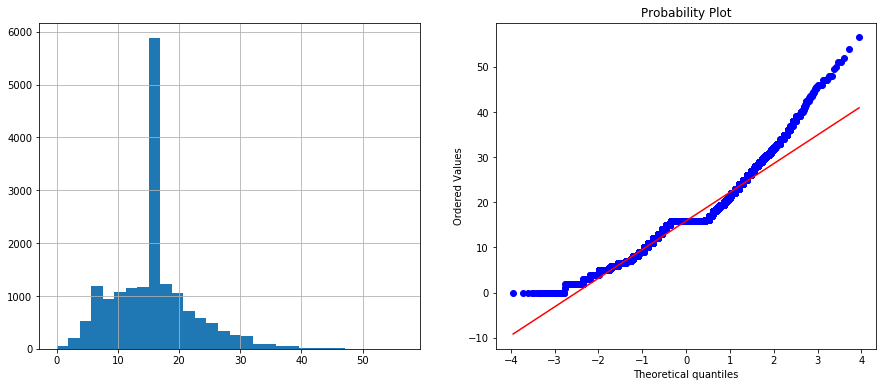

In [11]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
    
diagnostic_plots(data, 'wind_speed')

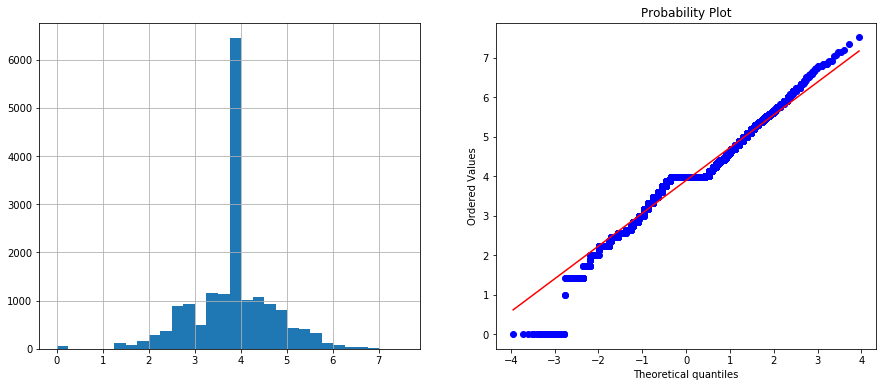

In [12]:
data['wind_speed_sqr'] = data['wind_speed']**(1/2) 
diagnostic_plots(data, 'wind_speed_sqr')